## When extracting faces from images, sometimes the algorithm returns crops that don't represent a face like: faces from paintings, drawings, t-shirts.  Also sometimes the face cropped is distant or too close or it takes the back of the head. 

## The idea of this model is to detect good faces and bad/no faces in a cropped image, in order to remove the irregular crops from the list of faces extracted from the image. That idea can potentially improve the accuracy of Deepfake Detector.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from os import listdir
from os.path import isfile, join, isdir

import glob
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import time
import glob 
from PIL import Image

from contextlib import contextmanager
import os
import functools
from scipy.stats.mstats import gmean

from scipy.stats.mstats import gmean


INPUT_PATH = '../input/deepfake-detection-challenge/'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import albumentations

### The following dataset was extracted from movies using Face Single Shoot Detector model with relaxed parameters to extract both high quality faces and bad quality faces and gargabe crops.
### Then the pictures are hand labelled in order to build two sets of images

In [4]:
data_dir = 'head_extract'
files0 = glob.glob( 'head_extract/no/*' )
files1 = glob.glob( 'head_extract/yes/*' )

print( len(files0), len(files1) )

TARGET = {}
for f in files0:
    TARGET[f]  = 0
for f in files1:
    TARGET[f]  = 1

In [7]:
#Set some augmentation to help generalization

train_transforms = albumentations.Compose([
    #albumentations.Transpose(p=0.05),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    
    albumentations.OneOf([
        albumentations.RandomBrightness(limit=0.2),
        albumentations.RandomContrast(limit=0.2),
        albumentations.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=25, val_shift_limit=25, p=0.10),
    ], p=0.50),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 10.0)),
    ], p=0.10),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=0.250),
        albumentations.GridDistortion(num_steps=3, distort_limit=0.250),
        albumentations.ElasticTransform(alpha=3),
    ], p=0.005),
#     albumentations.CLAHE(clip_limit=1.0, p=0.7),
    
    #albumentations.Cutout(max_h_size=16, max_w_size=16, num_holes=1, p=1.00),

    albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, border_mode=1, p=1.00),
    #albumentations.Resize(64, 64),
    #albumentations.pytorch.ToTensor(),
])    
    
test_transforms = transforms.Compose([
    #transforms.Resize(64),
    #transforms.ToTensor(),
    ])


In [8]:
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler

class DeepFakeDataset(Dataset):
    def __init__(self, files, mode, TARGET, transform=None):

        self.files = files
        self.mode = mode
        self.image_size = 64
        self.transform = transform
        self.target = TARGET

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):

        file_path = self.files[index]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (64, 64))

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image /= 255
        image = image.transpose(2, 0, 1)

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label = self.target[ self.files[index] ]
            return torch.tensor(image), torch.tensor(label).float() 

In [ ]:
print( len(files0), len(files1) )

files = files0 + files1
np.random.seed(2020)
np.random.shuffle( files )
print( len(files) )

dataset_show = DeepFakeDataset( files, 'train', TARGET, transform=train_transforms)

### Load some example from the hand labelled dataset

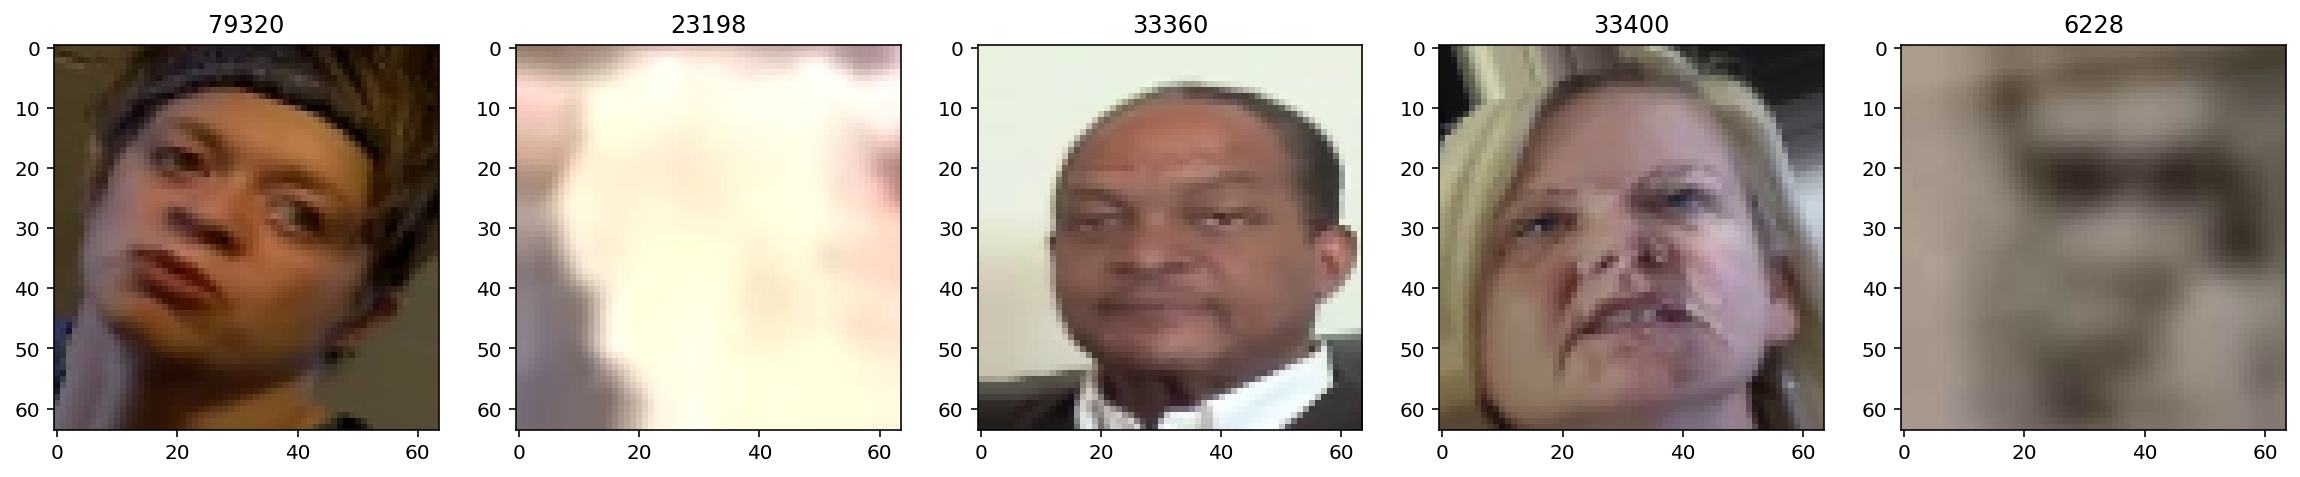

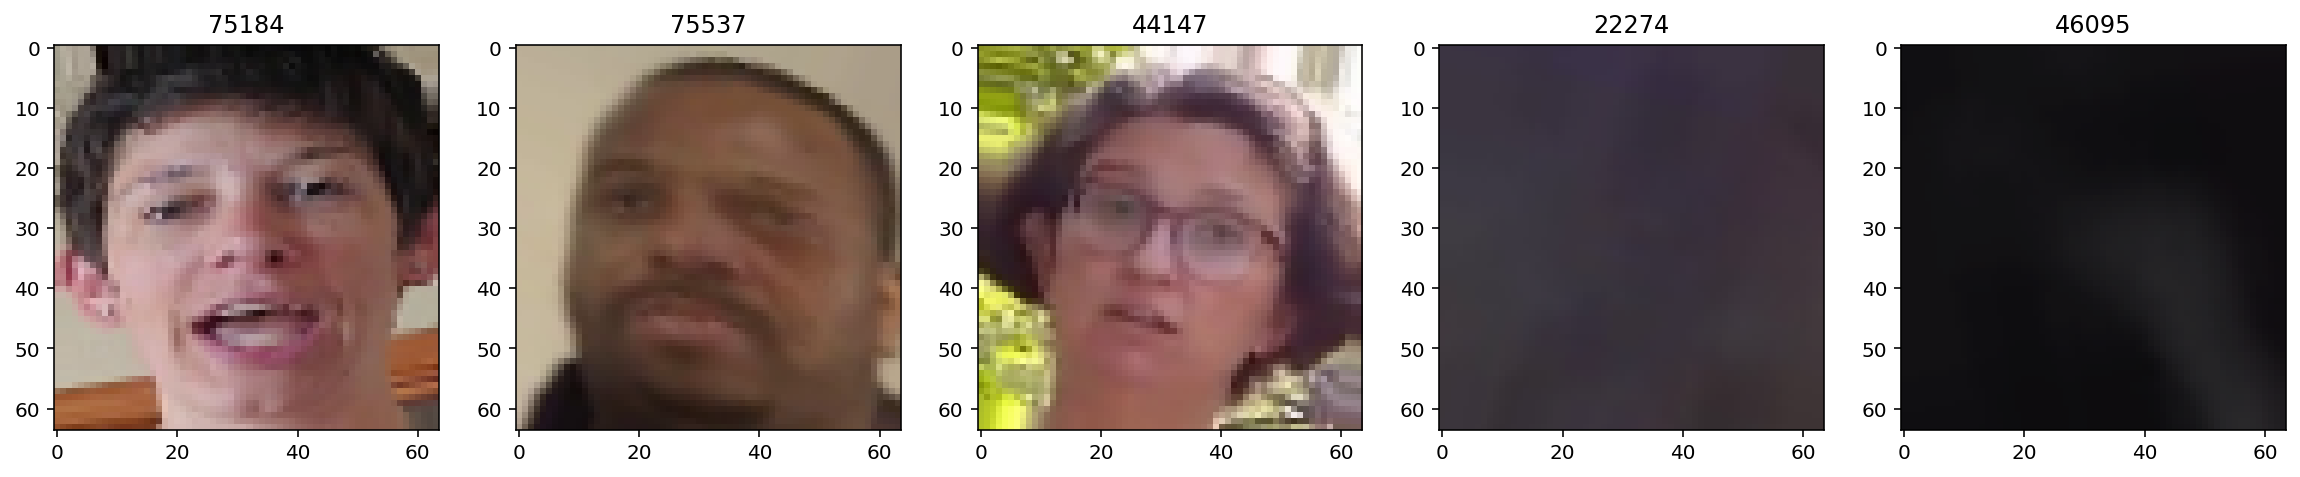

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(7, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(idx)

In [20]:
dataset_train = DeepFakeDataset( files[:95000], 'train', TARGET, transform=train_transforms)
dataset_valid = DeepFakeDataset( files[95000:], 'valid', TARGET, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=512, sampler=RandomSampler(dataset_train), num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=512, sampler=None, num_workers=8)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained = True )

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.50),
                                 nn.Linear(256, 1),
                                 nn.Sigmoid()
                        )
criterion = nn.BCELoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.train()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
#Train for 100 epoch or until converge

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

epochs = 100
steps = 0
running_loss = 0
train_losses, test_losses = [], []

for epoch in range(epochs):
    starttime = time.time()
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels.float())
            test_loss += batch_loss.item()
            accuracy += ((logps>0.5).float().T == labels).float().mean()
    
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(valid_loader))                    
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.4f}.. "
          f"Test loss: {test_loss/len(valid_loader):.4f}.. "
          f"Test accuracy: {accuracy/len(valid_loader):.4f}.. "
          f"time: {time.time() - starttime:.1f}"
         )
    running_loss = 0
    model.train()
        
torch.save(model, 'good-face-detector-1.pth')

/home/giba/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/giba/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 1/100.. Train loss: 0.2372.. Test loss: 0.1634.. Test accuracy: 0.9387.. time: 19.0


/home/giba/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([399])) that is different to the input size (torch.Size([399, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 2/100.. Train loss: 0.1546.. Test loss: 0.1363.. Test accuracy: 0.9459.. time: 17.9
Epoch 3/100.. Train loss: 0.1408.. Test loss: 0.1186.. Test accuracy: 0.9533.. time: 19.0
Epoch 4/100.. Train loss: 0.1297.. Test loss: 0.1220.. Test accuracy: 0.9494.. time: 17.9
Epoch 5/100.. Train loss: 0.1229.. Test loss: 0.1072.. Test accuracy: 0.9587.. time: 18.9
Epoch 6/100.. Train loss: 0.1163.. Test loss: 0.1042.. Test accuracy: 0.9630.. time: 19.1
Epoch 7/100.. Train loss: 0.1118.. Test loss: 0.1029.. Test accuracy: 0.9607.. time: 19.1


KeyboardInterrupt: 

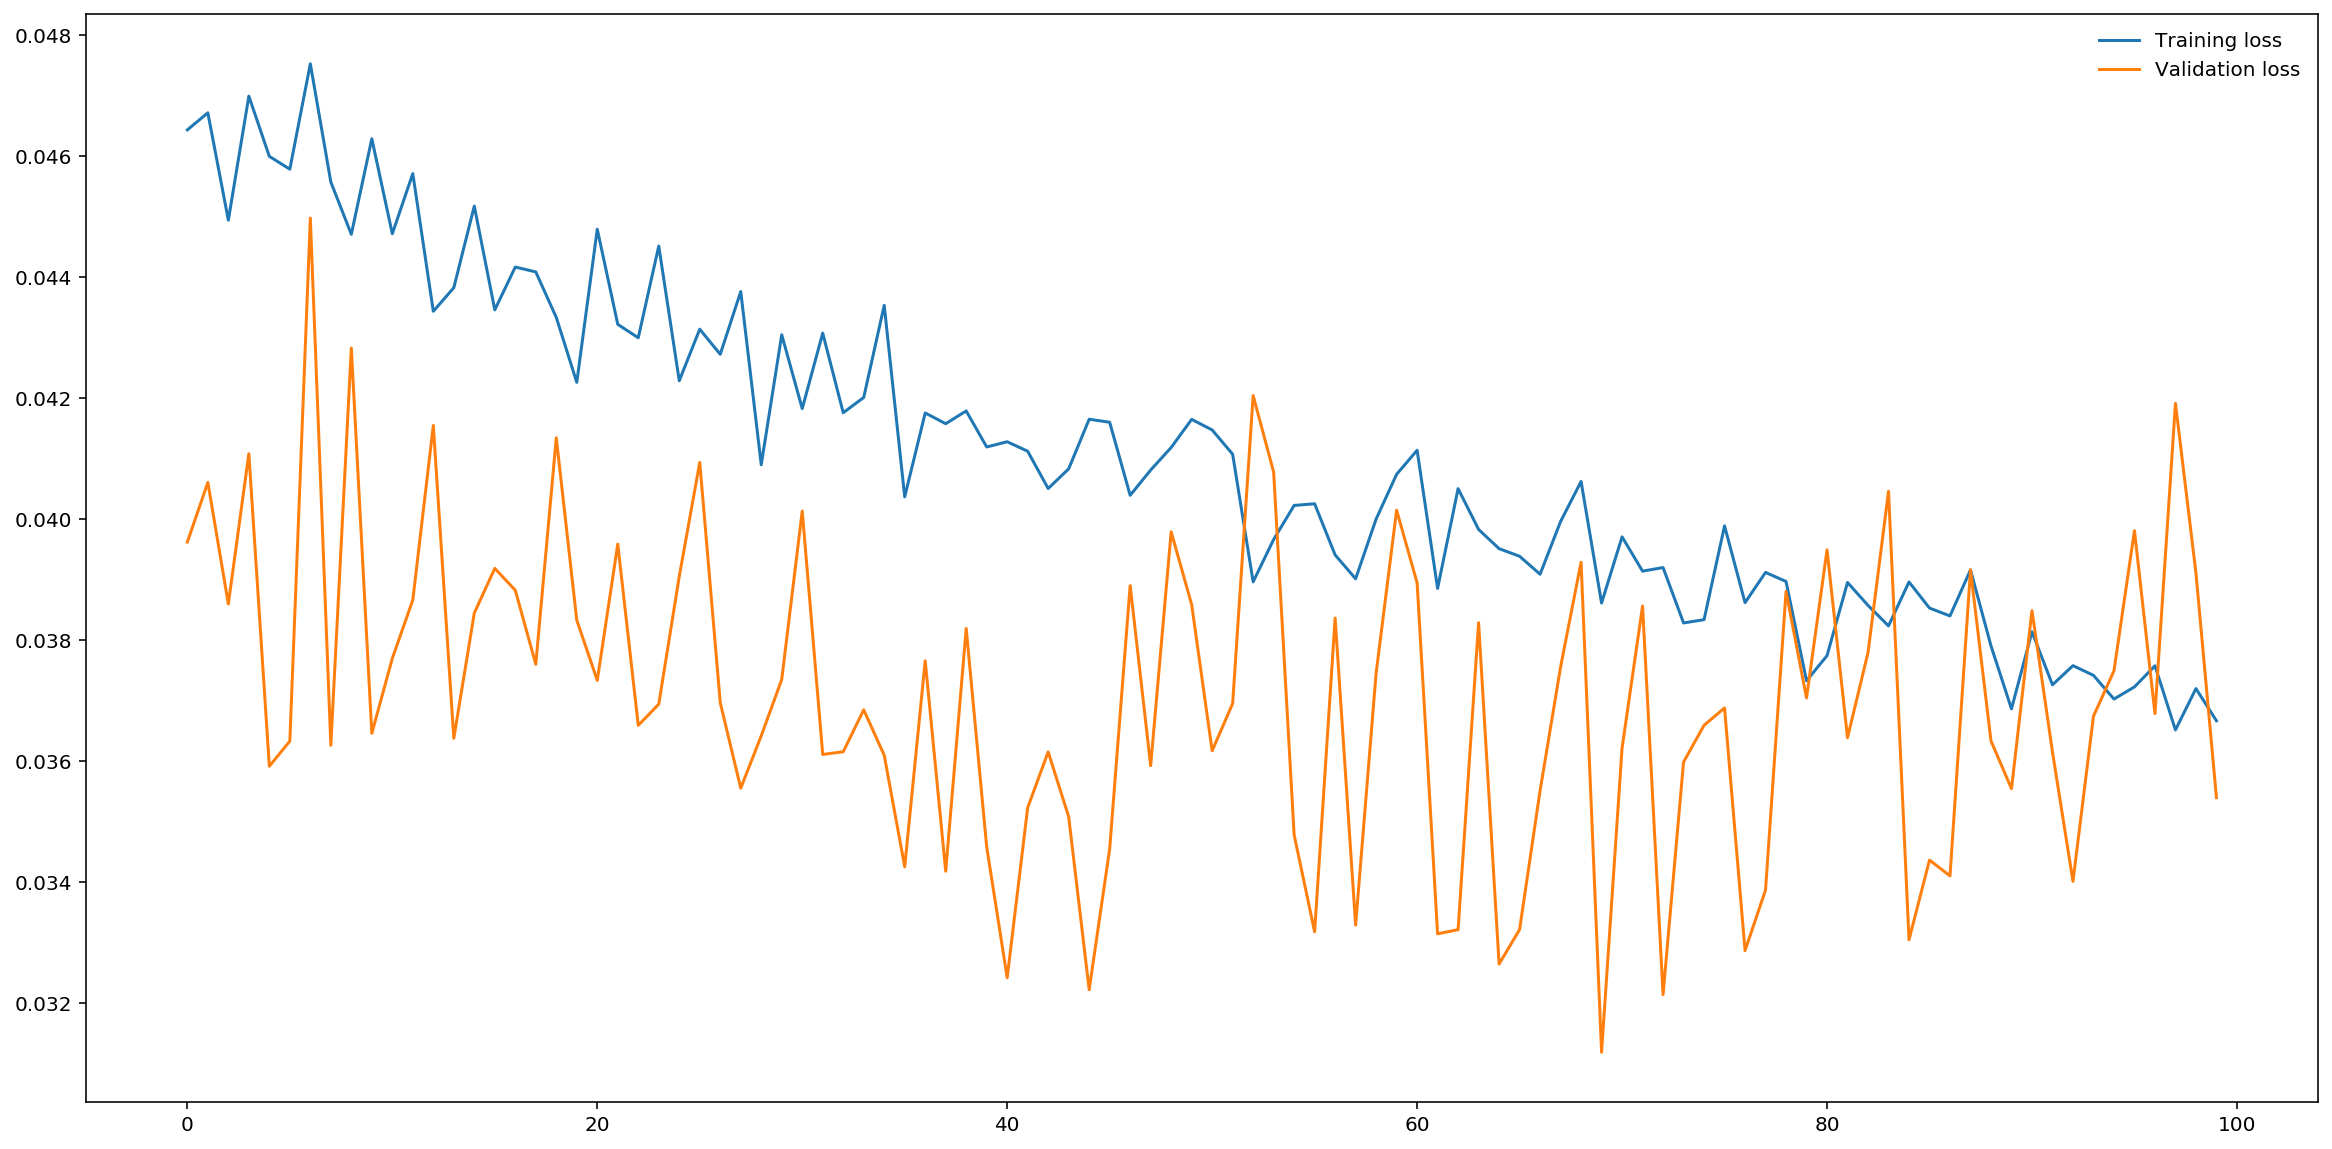

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

### Manually Decrease Learning Rate

In [16]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.00001)

epochs = 50
steps = 0
running_loss = 0
train_losses, test_losses = [], []

for epoch in range(epochs):
    starttime = time.time()
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels.float())
            test_loss += batch_loss.item()
            accuracy += ((logps>0.5).float().T == labels).float().mean()
    
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(valid_loader))                    
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.4f}.. "
          f"Test loss: {test_loss/len(valid_loader):.4f}.. "
          f"Test accuracy: {accuracy/len(valid_loader):.4f}.. "
          f"time: {time.time() - starttime:.1f}"
         )
    running_loss = 0
    model.train()
        
torch.save(model, 'good-face-detector-1.pth')

Epoch 1/200.. Train loss: 0.0368.. Test loss: 0.0339.. Test accuracy: 0.9866.. time: 18.0
Epoch 2/200.. Train loss: 0.0352.. Test loss: 0.0352.. Test accuracy: 0.9875.. time: 17.9
Epoch 3/200.. Train loss: 0.0355.. Test loss: 0.0343.. Test accuracy: 0.9872.. time: 18.2
Epoch 4/200.. Train loss: 0.0339.. Test loss: 0.0342.. Test accuracy: 0.9881.. time: 17.8
Epoch 5/200.. Train loss: 0.0354.. Test loss: 0.0361.. Test accuracy: 0.9858.. time: 18.1
Epoch 6/200.. Train loss: 0.0351.. Test loss: 0.0374.. Test accuracy: 0.9871.. time: 18.0
Epoch 7/200.. Train loss: 0.0345.. Test loss: 0.0355.. Test accuracy: 0.9868.. time: 18.0
Epoch 8/200.. Train loss: 0.0336.. Test loss: 0.0377.. Test accuracy: 0.9848.. time: 17.8
Epoch 9/200.. Train loss: 0.0360.. Test loss: 0.0345.. Test accuracy: 0.9868.. time: 17.9
Epoch 10/200.. Train loss: 0.0353.. Test loss: 0.0351.. Test accuracy: 0.9875.. time: 18.3
Epoch 11/200.. Train loss: 0.0341.. Test loss: 0.0340.. Test accuracy: 0.9878.. time: 17.8
Epoch 12

### Manually Decrease Learning Rate

In [14]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.000005)

epochs = 200
steps = 0
running_loss = 0
train_losses, test_losses = [], []

for epoch in range(epochs):
    starttime = time.time()
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels.float())
            test_loss += batch_loss.item()
            accuracy += ((logps>0.5).float().T == labels).float().mean()
    
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(valid_loader))                    
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.4f}.. "
          f"Test loss: {test_loss/len(valid_loader):.4f}.. "
          f"Test accuracy: {accuracy/len(valid_loader):.4f}.. "
          f"time: {time.time() - starttime:.1f}"
         )
    running_loss = 0
    model.train()


/home/giba/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/giba/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 1/200.. Train loss: 1.4718.. Test loss: 0.0314.. Test accuracy: 0.9871.. time: 18.4


/home/giba/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([399])) that is different to the input size (torch.Size([399, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 2/200.. Train loss: 0.0459.. Test loss: 0.0346.. Test accuracy: 0.9871.. time: 18.1
Epoch 3/200.. Train loss: 0.0401.. Test loss: 0.0330.. Test accuracy: 0.9867.. time: 18.3
Epoch 4/200.. Train loss: 0.0392.. Test loss: 0.0277.. Test accuracy: 0.9896.. time: 18.5
Epoch 5/200.. Train loss: 0.0392.. Test loss: 0.0298.. Test accuracy: 0.9894.. time: 18.6
Epoch 6/200.. Train loss: 0.0366.. Test loss: 0.0273.. Test accuracy: 0.9895.. time: 18.5
Epoch 7/200.. Train loss: 0.0371.. Test loss: 0.0303.. Test accuracy: 0.9891.. time: 19.1
Epoch 8/200.. Train loss: 0.0375.. Test loss: 0.0277.. Test accuracy: 0.9896.. time: 18.8
Epoch 9/200.. Train loss: 0.0376.. Test loss: 0.0290.. Test accuracy: 0.9896.. time: 20.1
Epoch 10/200.. Train loss: 0.0376.. Test loss: 0.0281.. Test accuracy: 0.9897.. time: 19.0
Epoch 11/200.. Train loss: 0.0379.. Test loss: 0.0278.. Test accuracy: 0.9907.. time: 18.7
Epoch 12/200.. Train loss: 0.0355.. Test loss: 0.0281.. Test accuracy: 0.9923.. time: 18.8
Epoch 1

/home/giba/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/giba/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/giba/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/giba/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be

# Write model weights to disk

In [ ]:
torch.save(model, 'good-face-detector-1.pth')

## Load the model to check the performance

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('good-face-detector-1.pth')
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
files0 = files[:95000 ]
files1 = files[ 95000:]
len(files0), len(files1)

(95000, 8128)

In [24]:
dataset_train = DeepFakeDataset( files[:95000], 'train', TARGET, transform=train_transforms)
dataset_valid = DeepFakeDataset( files[95000:], 'valid', TARGET, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=512, sampler=None, num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=512, sampler=None, num_workers=8)

In [25]:
ypred0 = []
ytrue0 = []
ypred1 = []
ytrue1 = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        ypred0.extend( np.ravel( logps.cpu().numpy() ) )
        ytrue0.extend( np.ravel( labels.cpu().numpy() ) )
    
    
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        ypred1.extend( np.ravel( logps.cpu().numpy() ) )
        ytrue1.extend( np.ravel( labels.cpu().numpy() ) )
        
ypred0 = np.array( ypred0 )
ytrue0 = np.array( ytrue0 )
ypred1 = np.array( ypred1 )
ytrue1 = np.array( ytrue1 )

In [26]:
len(ypred0),len(ypred1)

(95000, 8128)

In [27]:
np.mean( ypred0 ), np.mean( ypred1 )

(0.45204732, 0.44412795)

In [28]:
np.mean( ytrue0 ), np.mean( ytrue1 )

(0.4493895, 0.44131398)

In [33]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import confusion_matrix

print( roc_auc_score( ytrue0, ypred0 )  )
print( confusion_matrix( ytrue0, ypred0>0.4662835 ) ) 

0.9989146388269794
[[51475   833]
 [  516 42176]]


In [34]:
print( roc_auc_score( ytrue1, ypred1 )  )
print( confusion_matrix( ytrue1, ypred1>0.4662835 ) )

0.9989920230551896
[[4472   69]
 [  33 3554]]


### Good, AUC at 0.999